# 01__preprocess
# turn files of counts into large dataframe of counts
in this notebook, I load in the barcode counts that we got from the .fastq files and put everything in one nice dataframe. additionally, I filter the barcodes to only include those that have >= 5 reads in a given sample.

- throughout these notebooks, "pool1" refers to the TSS pool
- pool1 was performed in HepG2, HeLa, and K562

------

figures in this notebook:
- **Fig S3A**: heatmap of barcode count correlation between replicates

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

# import utils
sys.path.append("../../utils")
from plotting_utils import *

%matplotlib inline

In [2]:
sns.set(**NOTEBOOK_PRESET)
fontsize = NOTEBOOK_FONTSIZE

## functions

In [3]:
def import_dna(counts_dir, dna_f):
    """
    function that will import the DNA counts for a given experiment
    ----
    counts_dir: string defining where the counts files are stored
    dna_f: list of strings defining where the DNA counts files are
    
    returns a dataframe with barcodes + counts
    """
    dna_dfs = []
    for i in range(len(dna_f)):
        f = dna_f[i]
        cols = ["barcode", "dna_%s" % (i+1)]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t", header=None)
        tmp.columns = cols
        dna_dfs.append(tmp)
    if len(dna_dfs) > 1:
        dna = reduce(lambda x, y: pd.merge(x, y, on = "barcode"), dna_dfs)
    else:
        dna = dna_dfs[0]
    return dna

In [4]:
def import_rna(counts_dir, rna_f, dna):
    """
    function that will import the RNA counts for a given experiment
    ----
    counts_dir: string defining where the counts files are stored
    rna_f: list of strings defining where the RNA counts files are
    dna: dataframe w/ DNA counts
    
    returns a dataframe with barcodes + counts, incl. RNA
    """
    data = dna.copy()
    data_cols = list(dna.columns)
    for f in rna_f:
        rep = re.findall(r'\d+', f.split("__")[3])[0]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t", header=None)
        tmp.columns = ["barcode", "rna_%s" % rep]
        data_cols.append("rna_%s" % rep)
        data = data.merge(tmp, on="barcode", how="outer")
    return data, data_cols

## variables

In [5]:
counts_dir = "../../data/01__counts"

In [6]:
barcode_dna_read_threshold = 5
barcode_rna_read_threshold = 5

### DNA files

In [7]:
pool1_pMPRA1_dna_f = ["POOL1__pMPRA1__COUNTS.txt"]

### RNA files

In [8]:
pool1_pMPRA1_HeLa_rna_f = ["POOL1__pMPRA1__HeLa__rep1__COUNTS.txt",
                           "POOL1__pMPRA1__HeLa__rep2__COUNTS.txt",
                           "POOL1__pMPRA1__HeLa__rep3__COUNTS.txt", 
                           "POOL1__pMPRA1__HeLa__rep4__COUNTS.txt"]
pool1_pMPRA1_HeLa_out_f = "POOL1__pMPRA1__HeLa__all_counts.txt"

In [9]:
pool1_pMPRA1_HepG2_rna_f = ["POOL1__pMPRA1__HepG2__rep3__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep4__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep5__COUNTS.txt", 
                            "POOL1__pMPRA1__HepG2__rep6__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep7__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep8__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep9__COUNTS.txt", 
                            "POOL1__pMPRA1__HepG2__rep10__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep11__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep12__COUNTS.txt",
                            "POOL1__pMPRA1__HepG2__rep13__COUNTS.txt", 
                            "POOL1__pMPRA1__HepG2__rep14__COUNTS.txt"]
pool1_pMPRA1_HepG2_out_f = "POOL1__pMPRA1__HepG2__all_counts.txt"

In [10]:
pool1_pMPRA1_K562_rna_f = ["POOL1__pMPRA1__K562__rep1__COUNTS.txt",
                           "POOL1__pMPRA1__K562__rep2__COUNTS.txt",
                           "POOL1__pMPRA1__K562__rep3__COUNTS.txt", 
                           "POOL1__pMPRA1__K562__rep4__COUNTS.txt"]
pool1_pMPRA1_K562_out_f = "POOL1__pMPRA1__K562__all_counts.txt"

### Index Files

In [11]:
pool1_index_f = "../../data/00__index/tss_oligo_pool.index.txt"

## 1. import indexes

In [12]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool1_index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.1,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,CTCGTAACGGG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
1,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.2,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,ATACGCGATTG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
2,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.3,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,GAAACGTAAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
3,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.4,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,GTACTAAGAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
4,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.5,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,ACTTTCCGACG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....


## 2. import dna

In [13]:
pool1_pMPRA1_dna = import_dna(counts_dir, pool1_pMPRA1_dna_f)
pool1_pMPRA1_dna.head()

,barcode,dna_1
0,ACGACTTACTT,26
1,CCTAAAGAATC,801
2,ACCCGAGAATG,385
3,ACTTACTACGA,112
4,ACGCTTATGTG,80


## 3. import rna

In [14]:
pool1_pMPRA1_HeLa_data, pool1_pMPRA1_HeLa_cols = import_rna(counts_dir, pool1_pMPRA1_HeLa_rna_f, pool1_pMPRA1_dna)
pool1_pMPRA1_HeLa_data.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,NaN,NaN,NaN,1.0
1,CCTAAAGAATC,801.0,355.0,1.0,26.0,6.0
2,ACCCGAGAATG,385.0,760.0,2.0,NaN,NaN
3,ACTTACTACGA,112.0,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,80.0,NaN,NaN,NaN,118.0


In [15]:
pool1_pMPRA1_HepG2_data, pool1_pMPRA1_HepG2_cols = import_rna(counts_dir, pool1_pMPRA1_HepG2_rna_f, pool1_pMPRA1_dna)
pool1_pMPRA1_HepG2_data.head()

,barcode,dna_1,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,ACGACTTACTT,26.0,5.0,36.0,2.0,3.0,8.0,2.0,91.0,24.0,7.0,9.0,7.0,18.0
1,CCTAAAGAATC,801.0,341.0,579.0,733.0,546.0,656.0,1118.0,677.0,960.0,1124.0,683.0,825.0,848.0
2,ACCCGAGAATG,385.0,699.0,1528.0,1213.0,1261.0,951.0,1858.0,1239.0,1266.0,1766.0,1310.0,1431.0,1846.0
3,ACTTACTACGA,112.0,420.0,766.0,717.0,774.0,535.0,1331.0,779.0,787.0,732.0,769.0,659.0,1140.0
4,ACGCTTATGTG,80.0,29.0,106.0,83.0,146.0,36.0,218.0,75.0,112.0,50.0,122.0,69.0,108.0


In [16]:
pool1_pMPRA1_K562_data, pool1_pMPRA1_K562_cols = import_rna(counts_dir, pool1_pMPRA1_K562_rna_f, pool1_pMPRA1_dna)
pool1_pMPRA1_K562_data.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,NaN,NaN,NaN,NaN
1,CCTAAAGAATC,801.0,563.0,1030.0,605.0,1217.0
2,ACCCGAGAATG,385.0,316.0,829.0,391.0,873.0
3,ACTTACTACGA,112.0,1139.0,1297.0,741.0,814.0
4,ACGCTTATGTG,80.0,NaN,NaN,170.0,62.0


## 4. filter barcodes

In [17]:
# print HeLa df
pool1_pMPRA1_HeLa_data.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,NaN,NaN,NaN,1.0
1,CCTAAAGAATC,801.0,355.0,1.0,26.0,6.0
2,ACCCGAGAATG,385.0,760.0,2.0,NaN,NaN
3,ACTTACTACGA,112.0,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,80.0,NaN,NaN,NaN,118.0


In [18]:
# fill NA values with 0
pool1_pMPRA1_HeLa_data = pool1_pMPRA1_HeLa_data.fillna(0)
pool1_pMPRA1_HepG2_data = pool1_pMPRA1_HepG2_data.fillna(0)
pool1_pMPRA1_K562_data = pool1_pMPRA1_K562_data.fillna(0)
pool1_pMPRA1_HeLa_data.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,0.0,0.0,0.0,1.0
1,CCTAAAGAATC,801.0,355.0,1.0,26.0,6.0
2,ACCCGAGAATG,385.0,760.0,2.0,0.0,0.0
3,ACTTACTACGA,112.0,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,80.0,0.0,0.0,0.0,118.0


In [20]:
# subset dataframes to rows where DNA counts are greater than the threshold
pool1_pMPRA1_HeLa_data_filt = pool1_pMPRA1_HeLa_data[pool1_pMPRA1_HeLa_data["dna_1"] >= barcode_dna_read_threshold]
pool1_pMPRA1_HepG2_data_filt = pool1_pMPRA1_HepG2_data[pool1_pMPRA1_HepG2_data["dna_1"] >= barcode_dna_read_threshold]
pool1_pMPRA1_K562_data_filt = pool1_pMPRA1_K562_data[pool1_pMPRA1_K562_data["dna_1"] >= barcode_dna_read_threshold]
pool1_pMPRA1_HeLa_data_filt.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,0.0,0.0,0.0,1.0
1,CCTAAAGAATC,801.0,355.0,1.0,26.0,6.0
2,ACCCGAGAATG,385.0,760.0,2.0,0.0,0.0
3,ACTTACTACGA,112.0,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,80.0,0.0,0.0,0.0,118.0


In [21]:
# grab the RNA replicate column names
pool1_pMPRA1_HeLa_reps = [x for x in pool1_pMPRA1_HeLa_data_filt.columns if "rna_" in x]
pool1_pMPRA1_HepG2_reps = [x for x in pool1_pMPRA1_HepG2_data_filt.columns if "rna_" in x]
pool1_pMPRA1_K562_reps = [x for x in pool1_pMPRA1_K562_data_filt.columns if "rna_" in x]
pool1_pMPRA1_HeLa_reps

['rna_1', 'rna_2', 'rna_3', 'rna_4']

In [22]:
# if a replicate column has fewer than the RNA counst threshold, fill it with NA
pool1_pMPRA1_HeLa_data_filt[pool1_pMPRA1_HeLa_reps] = pool1_pMPRA1_HeLa_data_filt[pool1_pMPRA1_HeLa_data_filt > barcode_rna_read_threshold][pool1_pMPRA1_HeLa_reps]
pool1_pMPRA1_HepG2_data_filt[pool1_pMPRA1_HepG2_reps] = pool1_pMPRA1_HepG2_data_filt[pool1_pMPRA1_HepG2_data_filt > barcode_rna_read_threshold][pool1_pMPRA1_HepG2_reps]
pool1_pMPRA1_K562_data_filt[pool1_pMPRA1_K562_reps] = pool1_pMPRA1_K562_data_filt[pool1_pMPRA1_K562_data_filt > barcode_rna_read_threshold][pool1_pMPRA1_K562_reps]
pool1_pMPRA1_HeLa_data_filt.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,26.0,NaN,NaN,NaN,NaN
1,CCTAAAGAATC,801.0,355.0,NaN,26.0,6.0
2,ACCCGAGAATG,385.0,760.0,NaN,NaN,NaN
3,ACTTACTACGA,112.0,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,80.0,NaN,NaN,NaN,118.0


In [23]:
# count the # of barcodes that meet the DNA/RNA threshold requirements

all_names = ["pool1_pMPRA1_HeLa", "pool1_pMPRA1_HepG2", "pool1_pMPRA1_K562"]
all_dfs = [pool1_pMPRA1_HeLa_data_filt, pool1_pMPRA1_HepG2_data_filt, pool1_pMPRA1_K562_data_filt]
all_cols = [pool1_pMPRA1_HeLa_cols, pool1_pMPRA1_HepG2_cols, pool1_pMPRA1_K562_cols]

print("FILTERING RESULTS:")
for n, df, cs in zip(all_names, all_dfs, all_cols):
    index_len = len(pool1_index)
    dna_barc_len = len(df)
    dna_barc_perc = (float(dna_barc_len)/index_len)*100
    
    print("%s: from %s barcodes to %s at DNA level (%s%%)" % (n, index_len, dna_barc_len, dna_barc_perc))
    
    reps = [x for x in cs if "rna_" in x]
    for r in reps:
        rep = r.split("_")[1]
        rna_barc_len = sum(~pd.isnull(df[r]))
        rna_barc_perc = (float(rna_barc_len)/index_len)*100
        
        print("\trep %s: %s barcodes at RNA level (%s%%)" % (rep, rna_barc_len, rna_barc_perc))
    print("")

FILTERING RESULTS:
pool1_pMPRA1_HeLa: from 120000 barcodes to 104972 at DNA level (87.47666666666667%)
	rep 1: 42917 barcodes at RNA level (35.76416666666667%)
	rep 2: 36384 barcodes at RNA level (30.320000000000004%)
	rep 3: 34235 barcodes at RNA level (28.529166666666665%)
	rep 4: 34563 barcodes at RNA level (28.8025%)

pool1_pMPRA1_HepG2: from 120000 barcodes to 104972 at DNA level (87.47666666666667%)
	rep 3: 97325 barcodes at RNA level (81.10416666666667%)
	rep 4: 100382 barcodes at RNA level (83.65166666666667%)
	rep 5: 96451 barcodes at RNA level (80.37583333333333%)
	rep 6: 94855 barcodes at RNA level (79.04583333333333%)
	rep 7: 97024 barcodes at RNA level (80.85333333333334%)
	rep 8: 97224 barcodes at RNA level (81.02000000000001%)
	rep 9: 96321 barcodes at RNA level (80.2675%)
	rep 10: 98550 barcodes at RNA level (82.125%)
	rep 11: 97920 barcodes at RNA level (81.6%)
	rep 12: 97973 barcodes at RNA level (81.64416666666666%)
	rep 13: 97916 barcodes at RNA level (81.5966666666

## 5. heatmap comparing barcode counts

In [24]:
# start lists each containing "barcode"
pool1_pMPRA1_HeLa_cols = ["barcode"]
pool1_pMPRA1_HepG2_cols = ["barcode"]
pool1_pMPRA1_K562_cols = ["barcode"]

In [25]:
# extend lists with more detailed column names
pool1_pMPRA1_HeLa_cols.extend(["HeLa_%s" % x for x in pool1_pMPRA1_HeLa_reps])
pool1_pMPRA1_HepG2_cols.extend(["HepG2_%s" % x for x in pool1_pMPRA1_HepG2_reps])
pool1_pMPRA1_K562_cols.extend(["K562_%s" % x for x in pool1_pMPRA1_K562_reps])
pool1_pMPRA1_HeLa_cols

['barcode', 'HeLa_rna_1', 'HeLa_rna_2', 'HeLa_rna_3', 'HeLa_rna_4']

In [26]:
# drop the DNA column as it's the same for all of them
pool1_pMPRA1_HeLa_data_filt.drop("dna_1", axis=1, inplace=True)
pool1_pMPRA1_HepG2_data_filt.drop("dna_1", axis=1, inplace=True)
pool1_pMPRA1_K562_data_filt.drop("dna_1", axis=1, inplace=True)
pool1_pMPRA1_HeLa_data_filt.head()

,barcode,rna_1,rna_2,rna_3,rna_4
0,ACGACTTACTT,NaN,NaN,NaN,NaN
1,CCTAAAGAATC,355.0,NaN,26.0,6.0
2,ACCCGAGAATG,760.0,NaN,NaN,NaN
3,ACTTACTACGA,1240.0,3040.0,1560.0,2626.0
4,ACGCTTATGTG,NaN,NaN,NaN,118.0


In [27]:
# set new column names
pool1_pMPRA1_HeLa_data_filt.columns = pool1_pMPRA1_HeLa_cols
pool1_pMPRA1_HepG2_data_filt.columns = pool1_pMPRA1_HepG2_cols
pool1_pMPRA1_K562_data_filt.columns = pool1_pMPRA1_K562_cols

In [29]:
# merge all dataframes and correlate them
all_pool1 = pool1_pMPRA1_HeLa_data_filt.merge(pool1_pMPRA1_HepG2_data_filt, on="barcode").merge(pool1_pMPRA1_K562_data_filt, on = "barcode")
all_pool1_corr = all_pool1.corr(method="pearson")
all_pool1_corr

,HeLa_rna_1,HeLa_rna_2,HeLa_rna_3,HeLa_rna_4,HepG2_rna_3,HepG2_rna_4,HepG2_rna_5,HepG2_rna_6,HepG2_rna_7,HepG2_rna_8,HepG2_rna_9,HepG2_rna_10,HepG2_rna_11,HepG2_rna_12,HepG2_rna_13,HepG2_rna_14,K562_rna_1,K562_rna_2,K562_rna_3,K562_rna_4
HeLa_rna_1,1.000000,0.936702,0.922865,0.907824,0.727047,0.731945,0.751425,0.743008,0.771082,0.771767,0.746961,0.730663,0.750407,0.747373,0.750503,0.746192,0.678083,0.670231,0.659478,0.650645
HeLa_rna_2,0.936702,1.000000,0.907413,0.894487,0.712442,0.717424,0.736020,0.728011,0.756887,0.757252,0.732134,0.717195,0.735714,0.732118,0.735208,0.731815,0.661463,0.651541,0.640694,0.633416
HeLa_rna_3,0.922865,0.907413,1.000000,0.888411,0.696894,0.700553,0.724150,0.716381,0.737761,0.738034,0.717145,0.698925,0.717595,0.714896,0.718097,0.714663,0.646182,0.636495,0.623656,0.613439
HeLa_rna_4,0.907824,0.894487,0.888411,1.000000,0.692917,0.696954,0.722374,0.715080,0.731473,0.731303,0.714118,0.694443,0.711940,0.709796,0.713225,0.709255,0.646198,0.637769,0.623892,0.613115
HepG2_rna_3,0.727047,0.712442,0.696894,0.692917,1.000000,0.992053,0.975811,0.973224,0.980953,0.976274,0.971145,0.970674,0.977335,0.977790,0.979372,0.978094,0.818415,0.835938,0.844497,0.828655
HepG2_rna_4,0.731945,0.717424,0.700553,0.696954,0.992053,1.000000,0.977450,0.975054,0.982917,0.978695,0.974437,0.972586,0.979535,0.980074,0.981852,0.980558,0.826709,0.844538,0.853116,0.837620
HepG2_rna_5,0.751425,0.736020,0.724150,0.722374,0.975811,0.977450,1.000000,0.990184,0.979488,0.974615,0.975843,0.960976,0.973123,0.976267,0.978049,0.977239,0.843838,0.860050,0.864305,0.844347
HepG2_rna_6,0.743008,0.728011,0.716381,0.715080,0.973224,0.975054,0.990184,1.000000,0.975979,0.971693,0.973767,0.957454,0.970431,0.973651,0.975549,0.975119,0.841376,0.858395,0.862135,0.842188
HepG2_rna_7,0.771082,0.756887,0.737761,0.731473,0.980953,0.982917,0.979488,0.975979,1.000000,0.992223,0.980719,0.975728,0.989428,0.990504,0.990288,0.989475,0.843364,0.859622,0.869721,0.856253
HepG2_rna_8,0.771767,0.757252,0.738034,0.731303,0.976274,0.978695,0.974615,0.971693,0.992223,1.000000,0.978690,0.972744,0.988643,0.990019,0.989125,0.988671,0.840761,0.857876,0.867762,0.855249


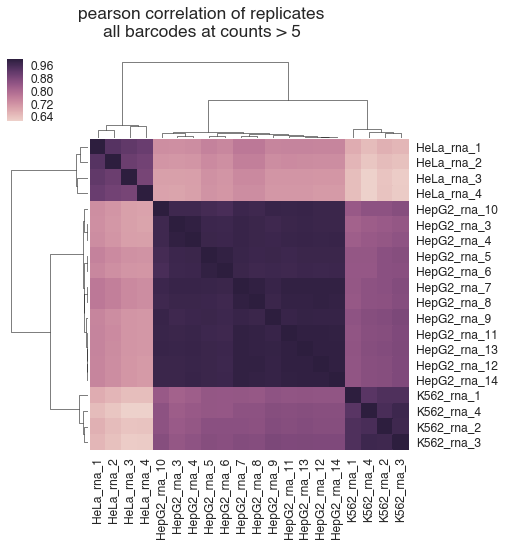

In [30]:
# make a heatmap

# set the colormap
cmap = sns.cubehelix_palette(as_cmap=True)

# create the heatmap object
cg = sns.clustermap(all_pool1_corr, figsize=(7.2,7.2), cmap=cmap, annot=False)

# rotate the labels so they don't overlap
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# add a title
plt.suptitle("pearson correlation of replicates\nall barcodes at counts > 5")

# save it
# cg.savefig("Fig_S3A.pdf", dpi="figure", transparent=True, bbox_inches="tight")

In [31]:
all_pool1.head()

,barcode,HeLa_rna_1,HeLa_rna_2,HeLa_rna_3,HeLa_rna_4,HepG2_rna_3,HepG2_rna_4,HepG2_rna_5,HepG2_rna_6,HepG2_rna_7,...,HepG2_rna_9,HepG2_rna_10,HepG2_rna_11,HepG2_rna_12,HepG2_rna_13,HepG2_rna_14,K562_rna_1,K562_rna_2,K562_rna_3,K562_rna_4
0,ACGACTTACTT,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,8.0,...,91.0,24.0,7.0,9.0,7.0,18.0,NaN,NaN,NaN,NaN
1,CCTAAAGAATC,355.0,NaN,26.0,6.0,341.0,579.0,733.0,546.0,656.0,...,677.0,960.0,1124.0,683.0,825.0,848.0,563.0,1030.0,605.0,1217.0
2,ACCCGAGAATG,760.0,NaN,NaN,NaN,699.0,1528.0,1213.0,1261.0,951.0,...,1239.0,1266.0,1766.0,1310.0,1431.0,1846.0,316.0,829.0,391.0,873.0
3,ACTTACTACGA,1240.0,3040.0,1560.0,2626.0,420.0,766.0,717.0,774.0,535.0,...,779.0,787.0,732.0,769.0,659.0,1140.0,1139.0,1297.0,741.0,814.0
4,ACGCTTATGTG,NaN,NaN,NaN,118.0,29.0,106.0,83.0,146.0,36.0,...,75.0,112.0,50.0,122.0,69.0,108.0,NaN,NaN,170.0,62.0
